In [1]:
!nvidia-smi

Mon Jan 20 06:22:46 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME =os.getcwd()
print(HOME)

/content


In [4]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 31.1/112.6 GB disk)


# inference with model pre-trained on custom dataset

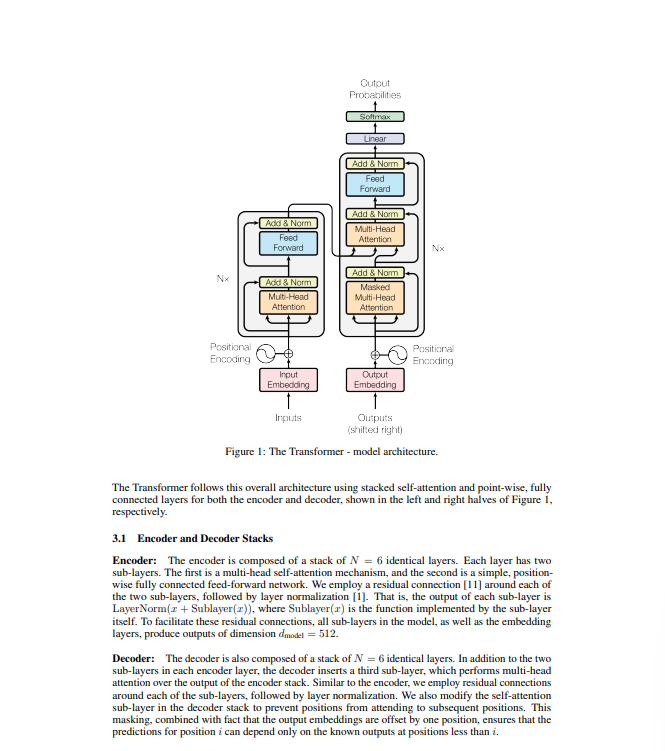

In [5]:
from IPython.display import Image as IPyImage
IPyImage(filename=f"{HOME}/Screenshot 2025-01-20 105204.png",width=600)


In [6]:
from ultralytics import YOLO
from PIL  import Image
import requests
model =YOLO('yolo11n.pt')
image =Image.open('/content/Screenshot 2025-01-20 105204.png')
result =model.predict(image,conf=0.25)[0]


100%|██████████| 5.35M/5.35M [00:00<00:00, 90.1MB/s]



0: 640x576 (no detections), 72.9ms
Speed: 26.9ms preprocess, 72.9ms inference, 94.4ms postprocess per image at shape (1, 3, 640, 576)


In [7]:
result.boxes.xyxy

tensor([], device='cuda:0', size=(0, 4))

In [8]:
result.boxes.cls


tensor([], device='cuda:0')

In [12]:
import supervision as sv
detections =sv.Detections.from_ultralytics(result)


In [13]:
detections

Detections(xyxy=array([], shape=(0, 4), dtype=float32), mask=None, confidence=array([], dtype=float32), class_id=array([], dtype=int64), tracker_id=None, data={'class_name': array([], dtype=float64)}, metadata={})

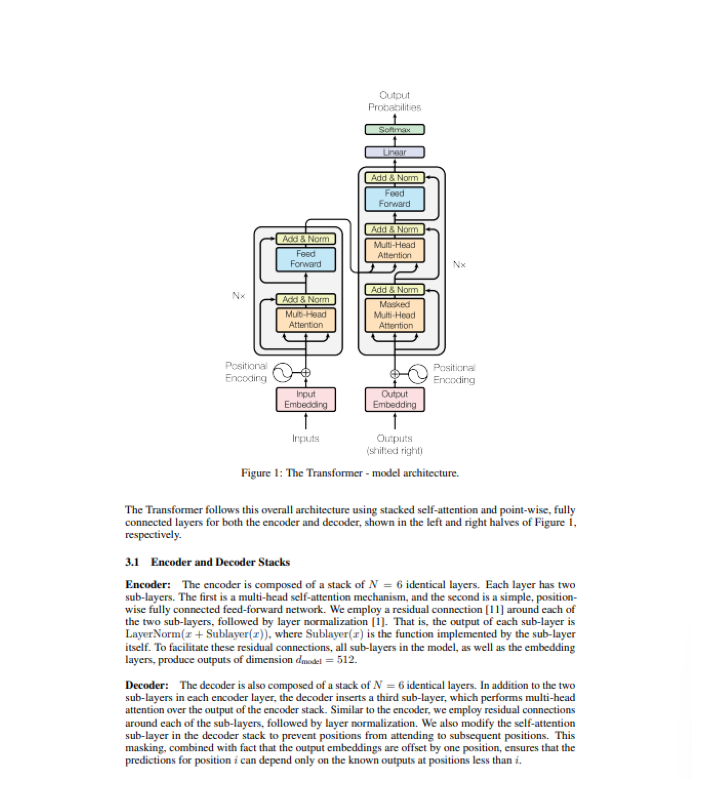

In [16]:
from typing_extensions import Annotated
box_annotator =sv.BoxAnnotator()
label_annotator  =sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image =image.copy()
annotated_image =box_annotator.annotate(annotated_image,detections=detections)
annotated_image =label_annotator.annotate(annotated_image,detections=detections)

sv.plot_image(annotated_image,size=(10,10))



*there are no detect because we not fine-tuning the dataset*

# Fine-tune YOLO11 on custom dataset

In [17]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

ROBOFLOW_API_KEY =userdata.get('ROBOFLOW_API_KEY')
rf =Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("huyifei").project("tft-id")
version = project.version(1)
dataset = version.download("yolov11")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to TFT-ID-1 in yolov11:: 100%|██████████| 17224/17224 [00:32<00:00, 534.89it/s] 


# custom Training

In [18]:
dataset.location



'/content/datasets/TFT-ID-1'

In [19]:
%cd {HOME}

!yolo task =detect mode=train model=yolo11n.pt data={dataset.location}/data.yaml epochs=20 batch =62 imgsz=640 plots=True


/content
Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/content/datasets/TFT-ID-1/data.yaml, epochs=20, time=None, patience=100, batch=62, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

In [20]:
!ls {HOME}/runs/detect/train/

args.yaml					     R_curve.png	  val_batch0_labels.jpg
confusion_matrix_normalized.png			     results.csv	  val_batch0_pred.jpg
confusion_matrix.png				     results.png	  val_batch1_labels.jpg
events.out.tfevents.1737357570.02c8bd32005f.14534.0  train_batch0.jpg	  val_batch1_pred.jpg
F1_curve.png					     train_batch1250.jpg  val_batch2_labels.jpg
labels_correlogram.jpg				     train_batch1251.jpg  val_batch2_pred.jpg
labels.jpg					     train_batch1252.jpg  weights
P_curve.png					     train_batch1.jpg
PR_curve.png					     train_batch2.jpg


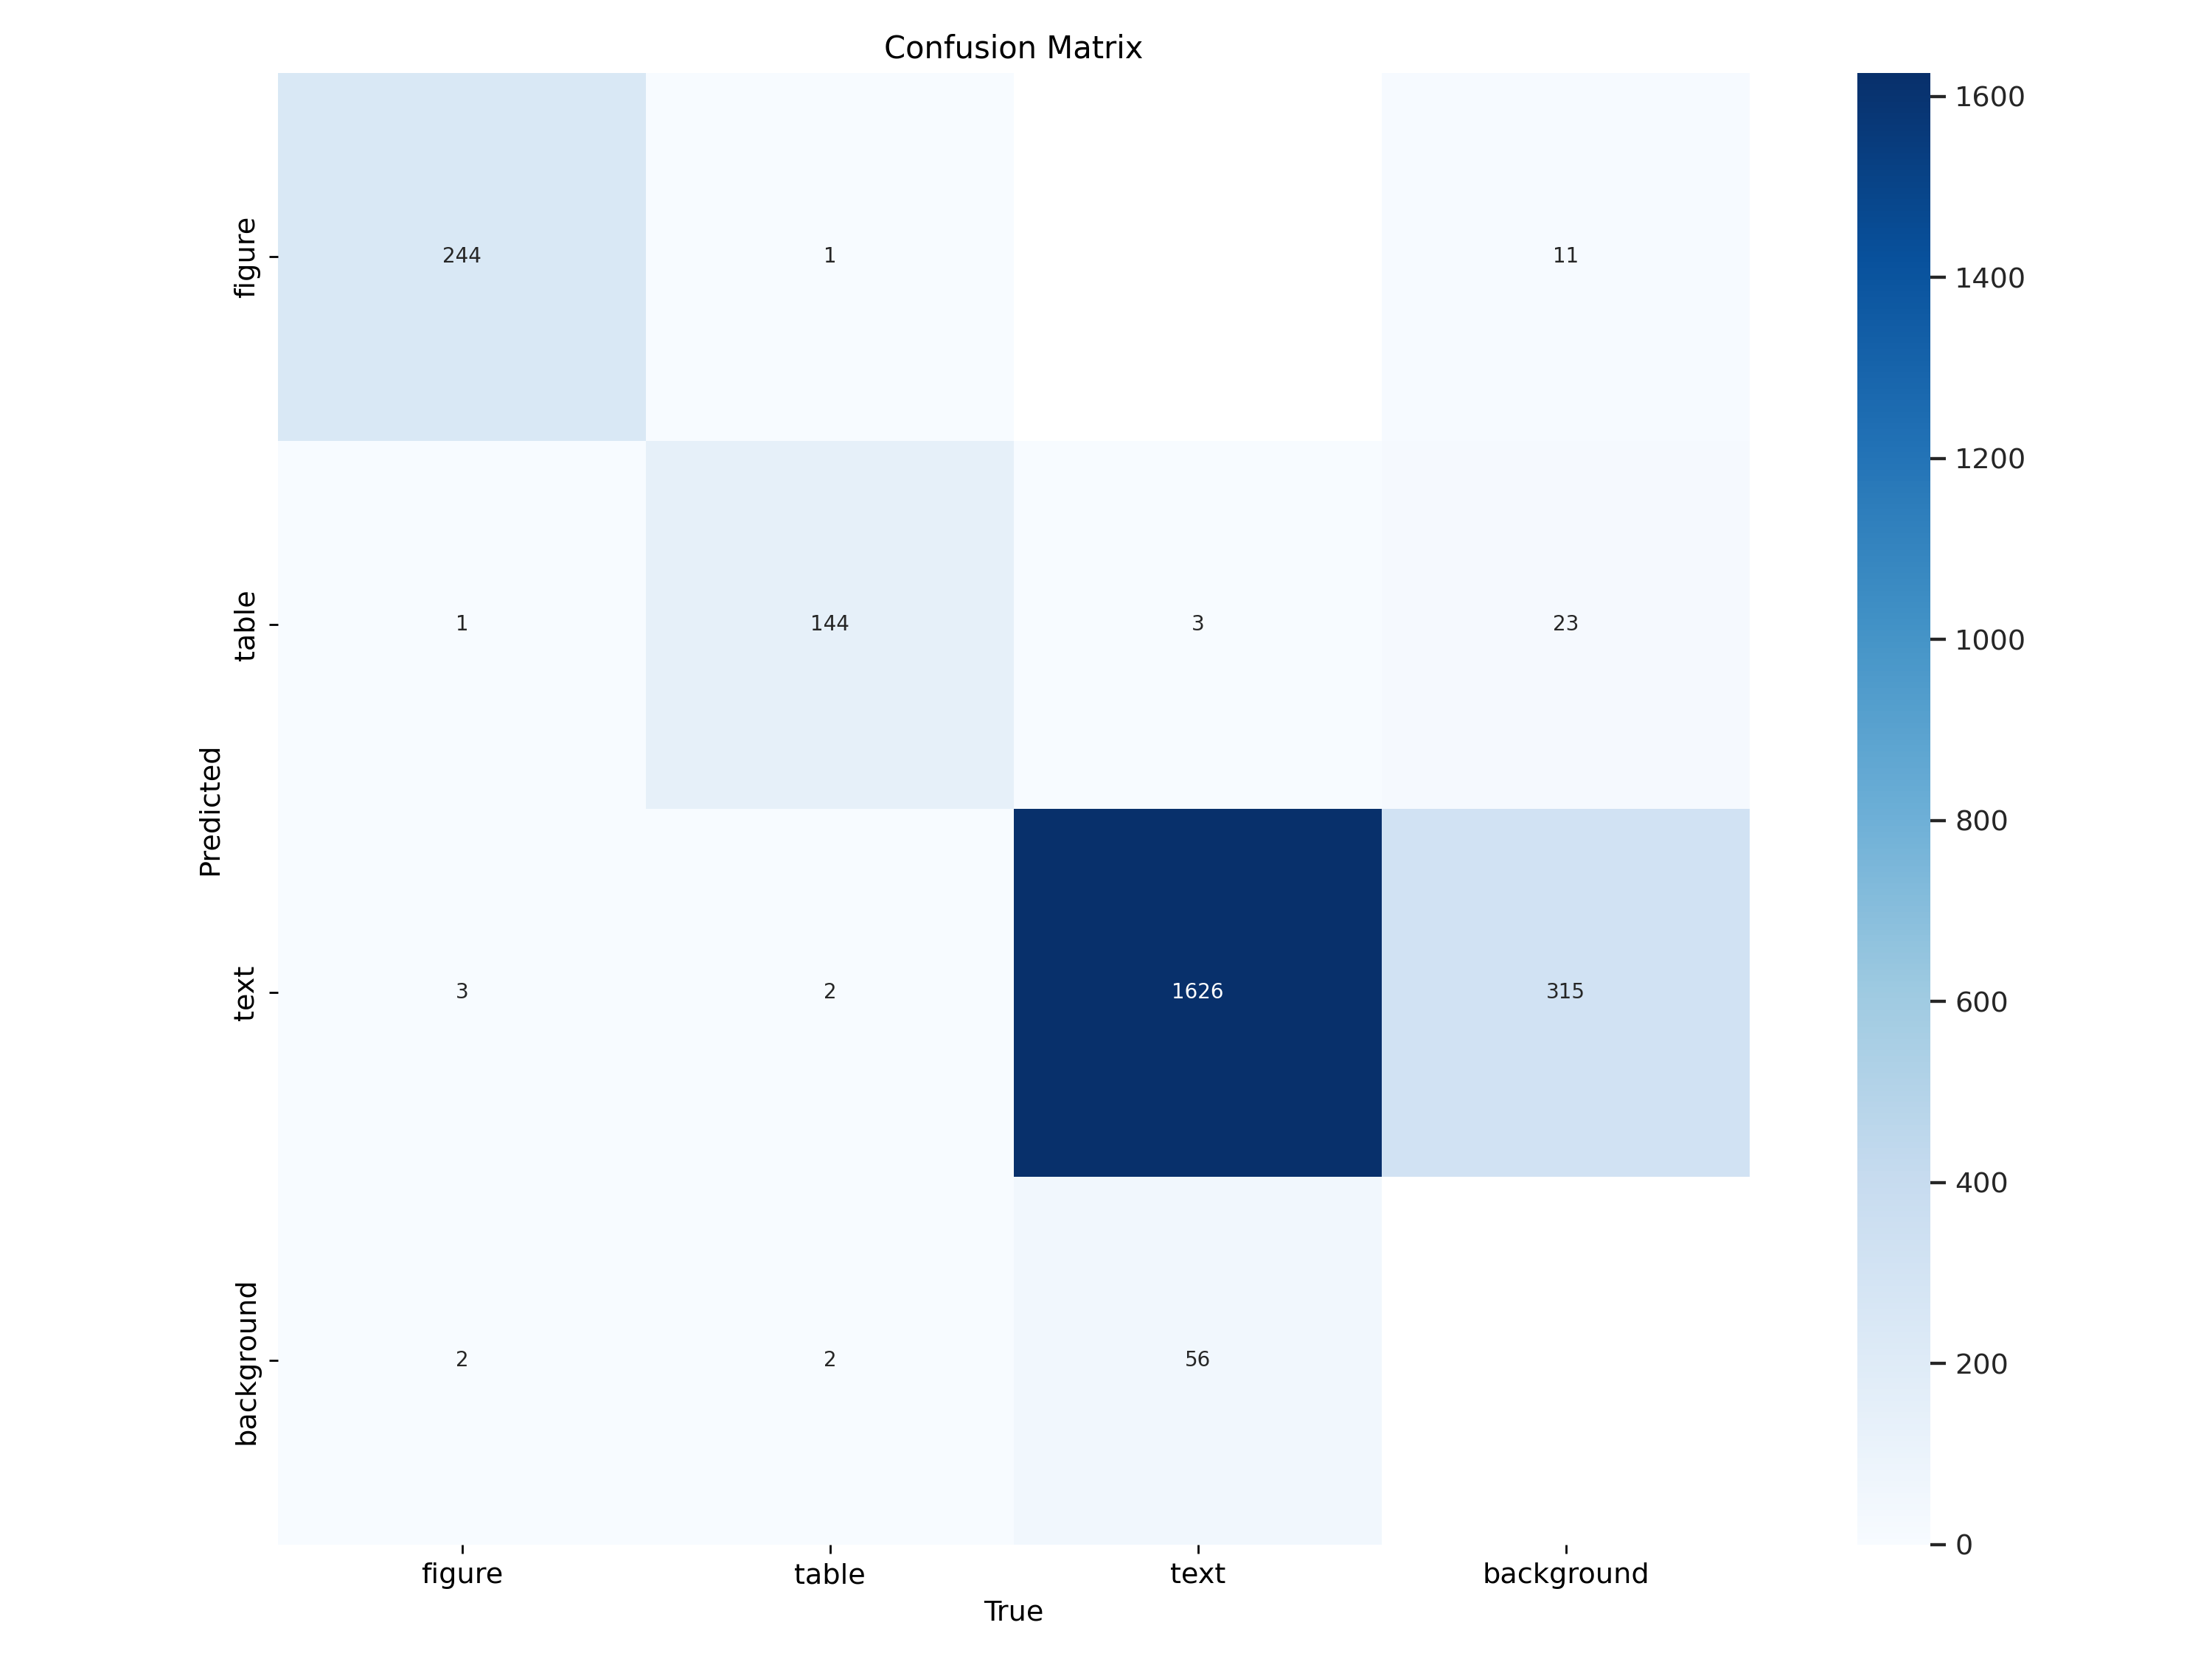

In [21]:
from IPython.display import Image as IPyImage
IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png',width=600)


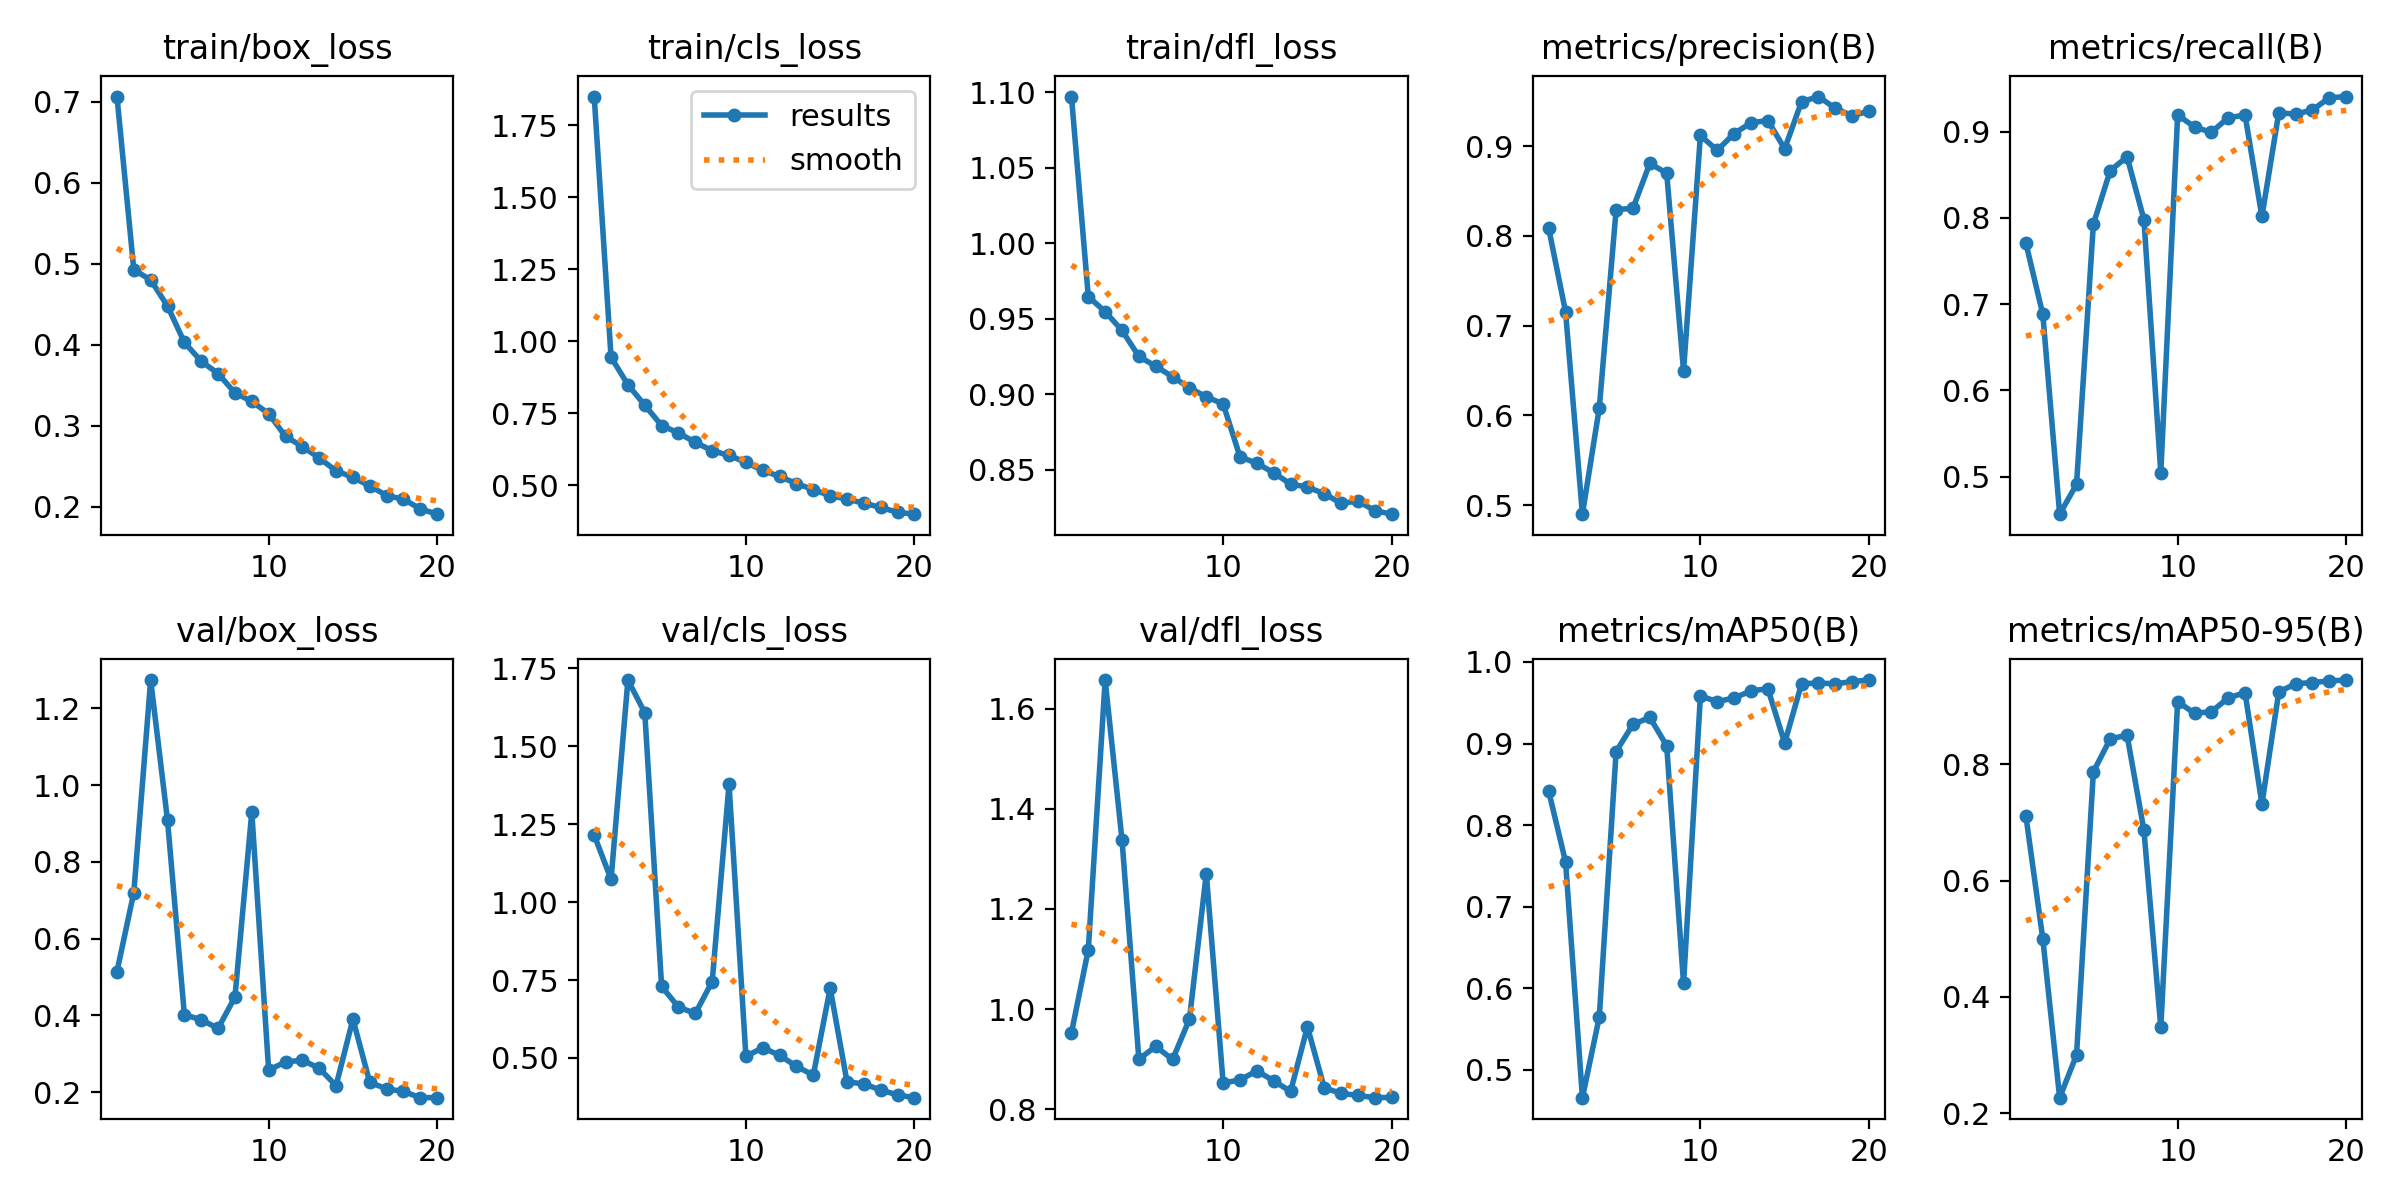

In [23]:
from IPython.display import Image as IPyImage
IPyImage(filename=f"{HOME}/runs/detect/train/results.png",width=600)


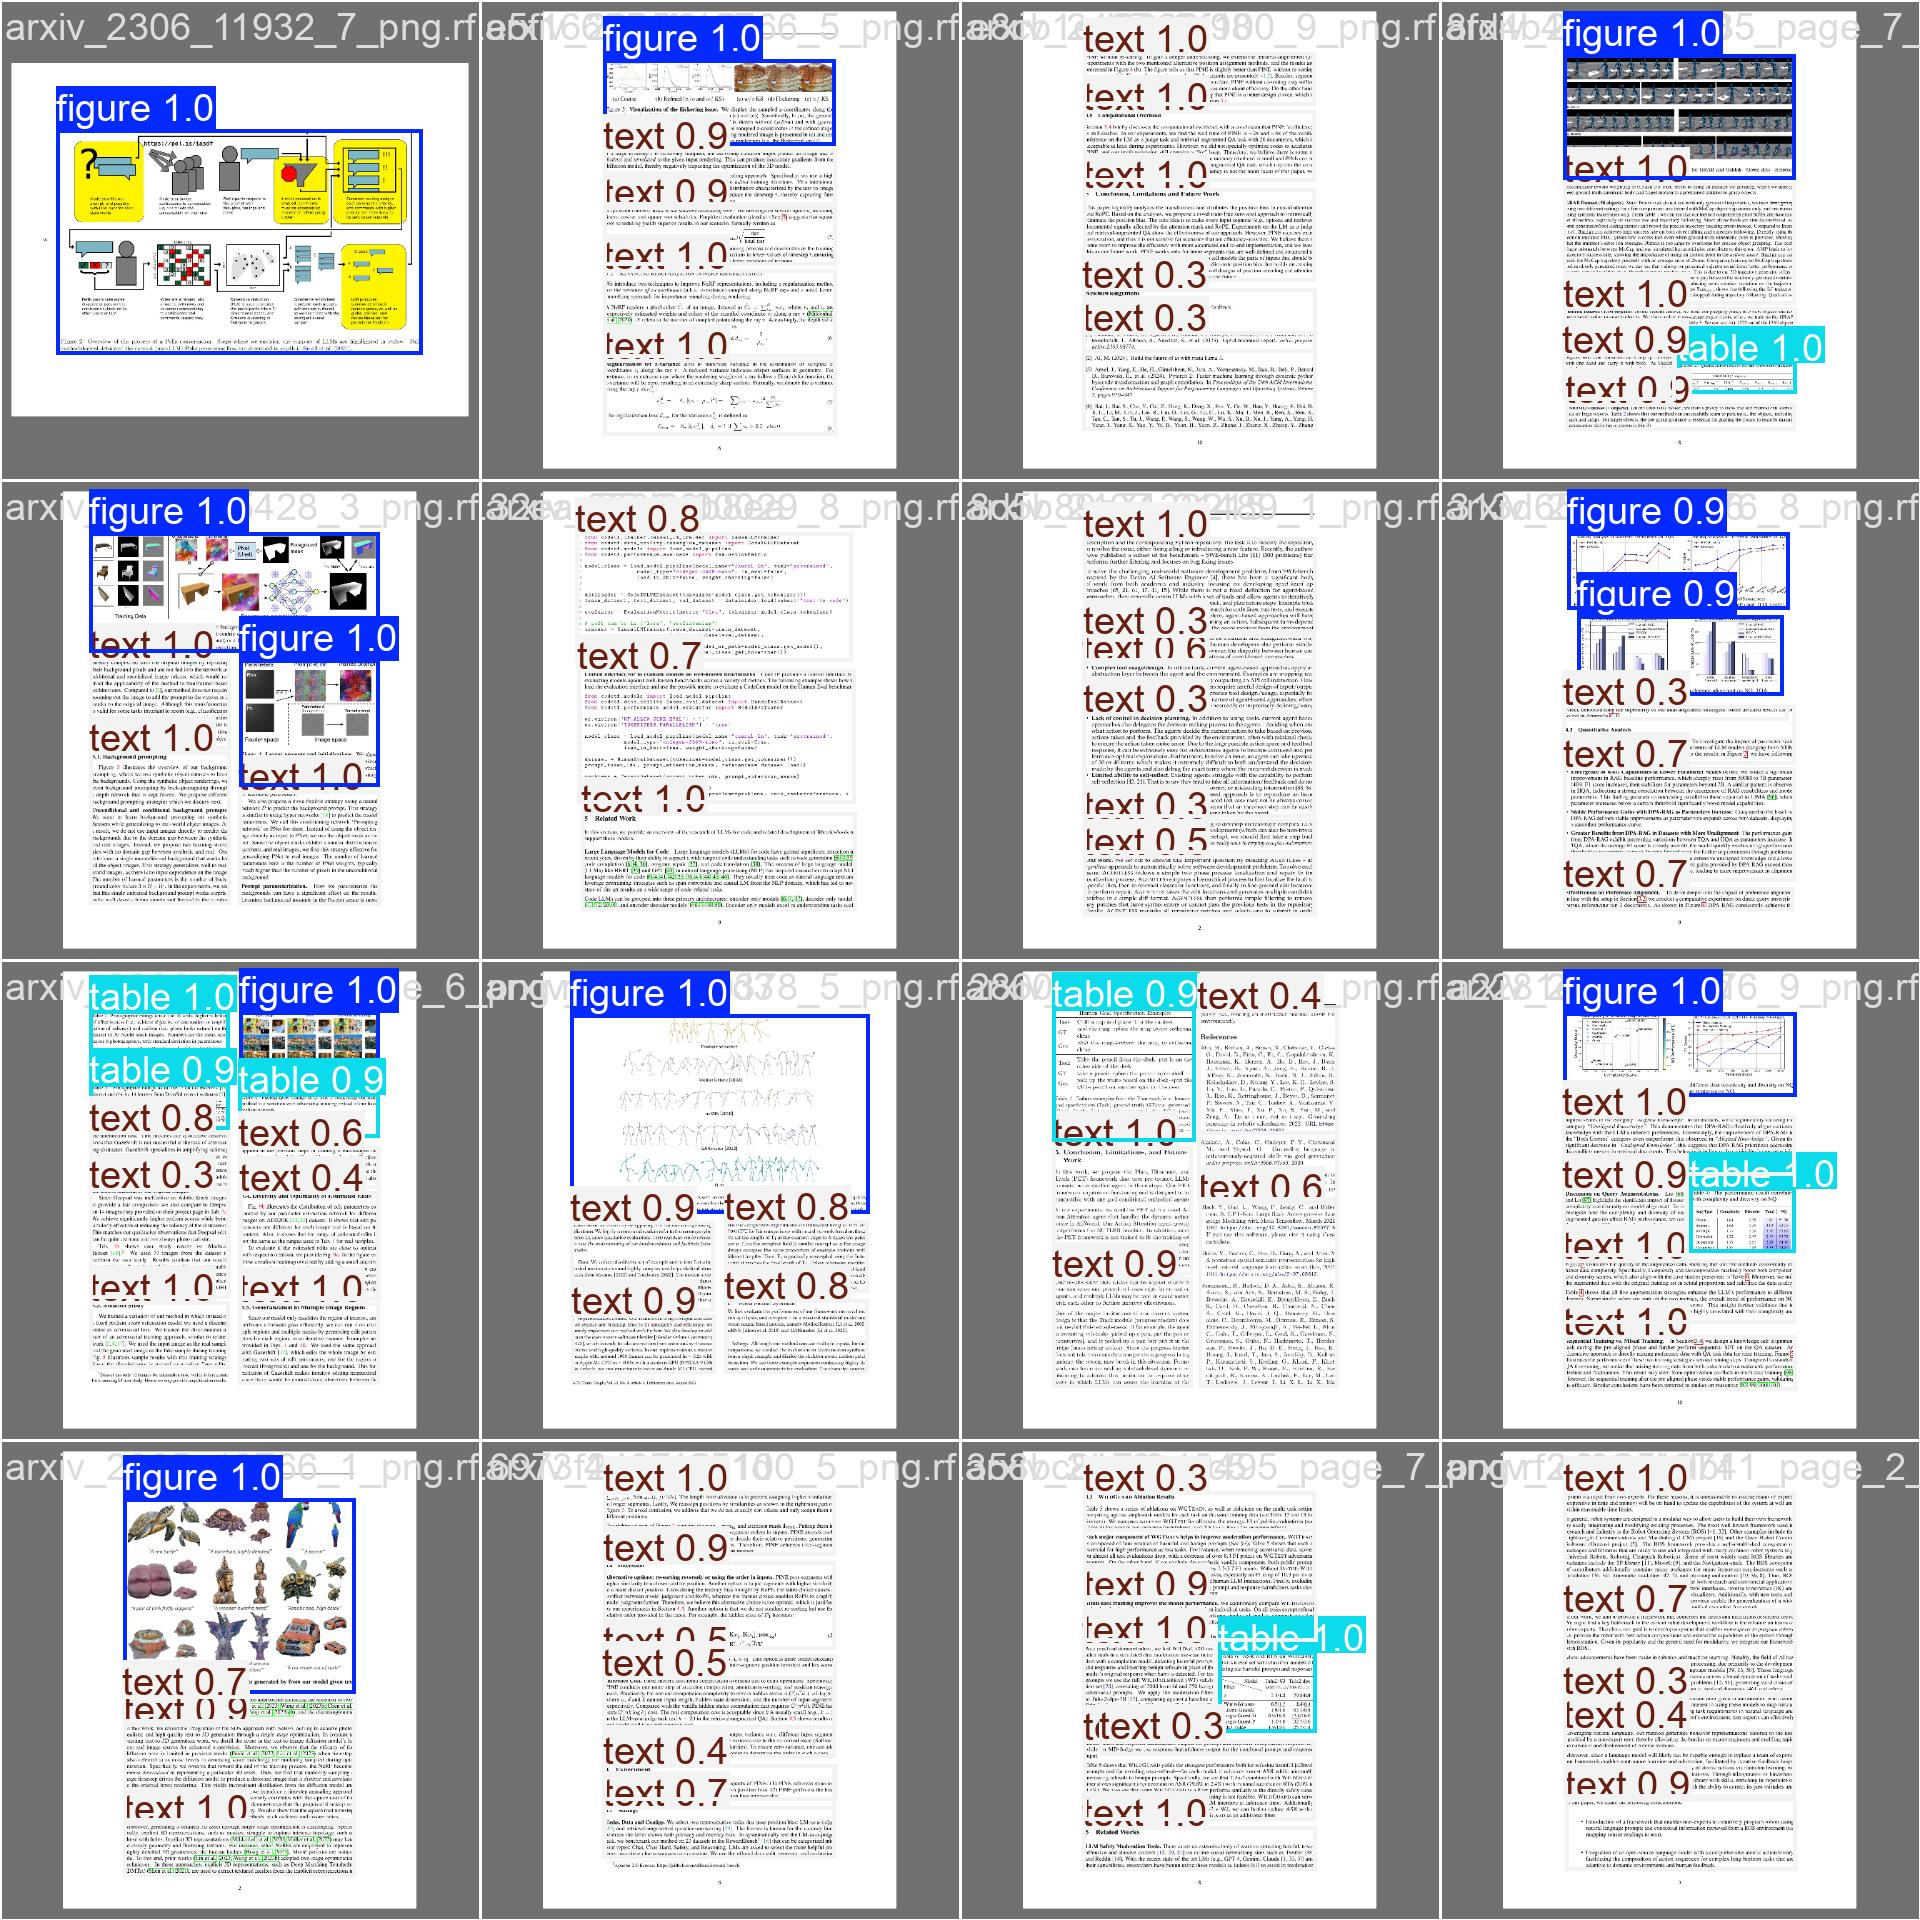

In [24]:
from IPython.display import Image as IPyImage
IPyImage(filename=f"{HOME}/runs/detect/train/val_batch0_pred.jpg",width=640)



# Validate fine-tuned Model

In [26]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml


Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /content/datasets/TFT-ID-1/valid/labels.cache... 431 images, 2 backgrounds, 0 corrupt: 100% 431/431 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 27/27 [00:08<00:00,  3.10it/s]
                   all        431       2084      0.938      0.943      0.975      0.945
                figure        196        250      0.972      0.968      0.988       0.97
                 table        106        149      0.899      0.953      0.966      0.952
                  text        422       1685      0.945      0.909      0.972      0.914
Speed: 0.7ms preprocess, 4.8ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


# imference with custom model

In [27]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.50 source={dataset.location}/test/images save=True


Ultralytics 8.3.64 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs

image 1/430 /content/datasets/TFT-ID-1/test/images/arxiv_2305_02412_3_png.rf.32f6409a183be4b92c631c71a6d780b9.jpg: 640x512 2 figures, 4 texts, 42.4ms
image 2/430 /content/datasets/TFT-ID-1/test/images/arxiv_2305_02412_7_png.rf.7b62359e54e4d3351b4b13cc753c08ec.jpg: 640x512 1 figure, 2 tables, 2 texts, 8.7ms
image 3/430 /content/datasets/TFT-ID-1/test/images/arxiv_2305_02665_4_png.rf.815a85a442d156cdad1178f7f6952bd4.jpg: 640x480 1 figure, 4 texts, 42.3ms
image 4/430 /content/datasets/TFT-ID-1/test/images/arxiv_2305_02968_3_png.rf.36f288a156a4db6c10e060bdd912bdf2.jpg: 640x512 1 figure, 3 texts, 9.1ms
image 5/430 /content/datasets/TFT-ID-1/test/images/arxiv_2305_03689_0_png.rf.772b06c466575a3872bd3ff29c72b9bd.jpg: 640x512 3 texts, 8.5ms
image 6/430 /content/datasets/TFT-ID-1/test/images/arxiv_2305_03981_7_png.rf.c9f67ee6cda1d4

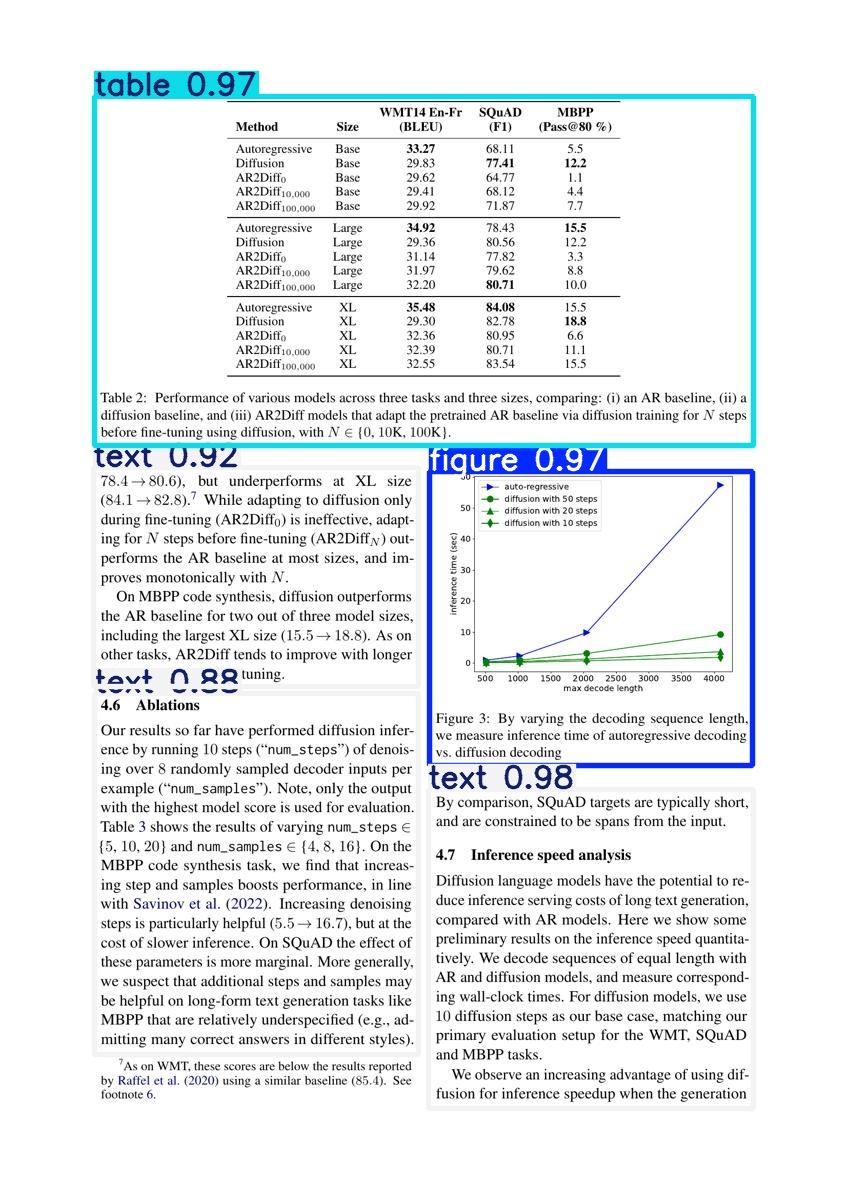

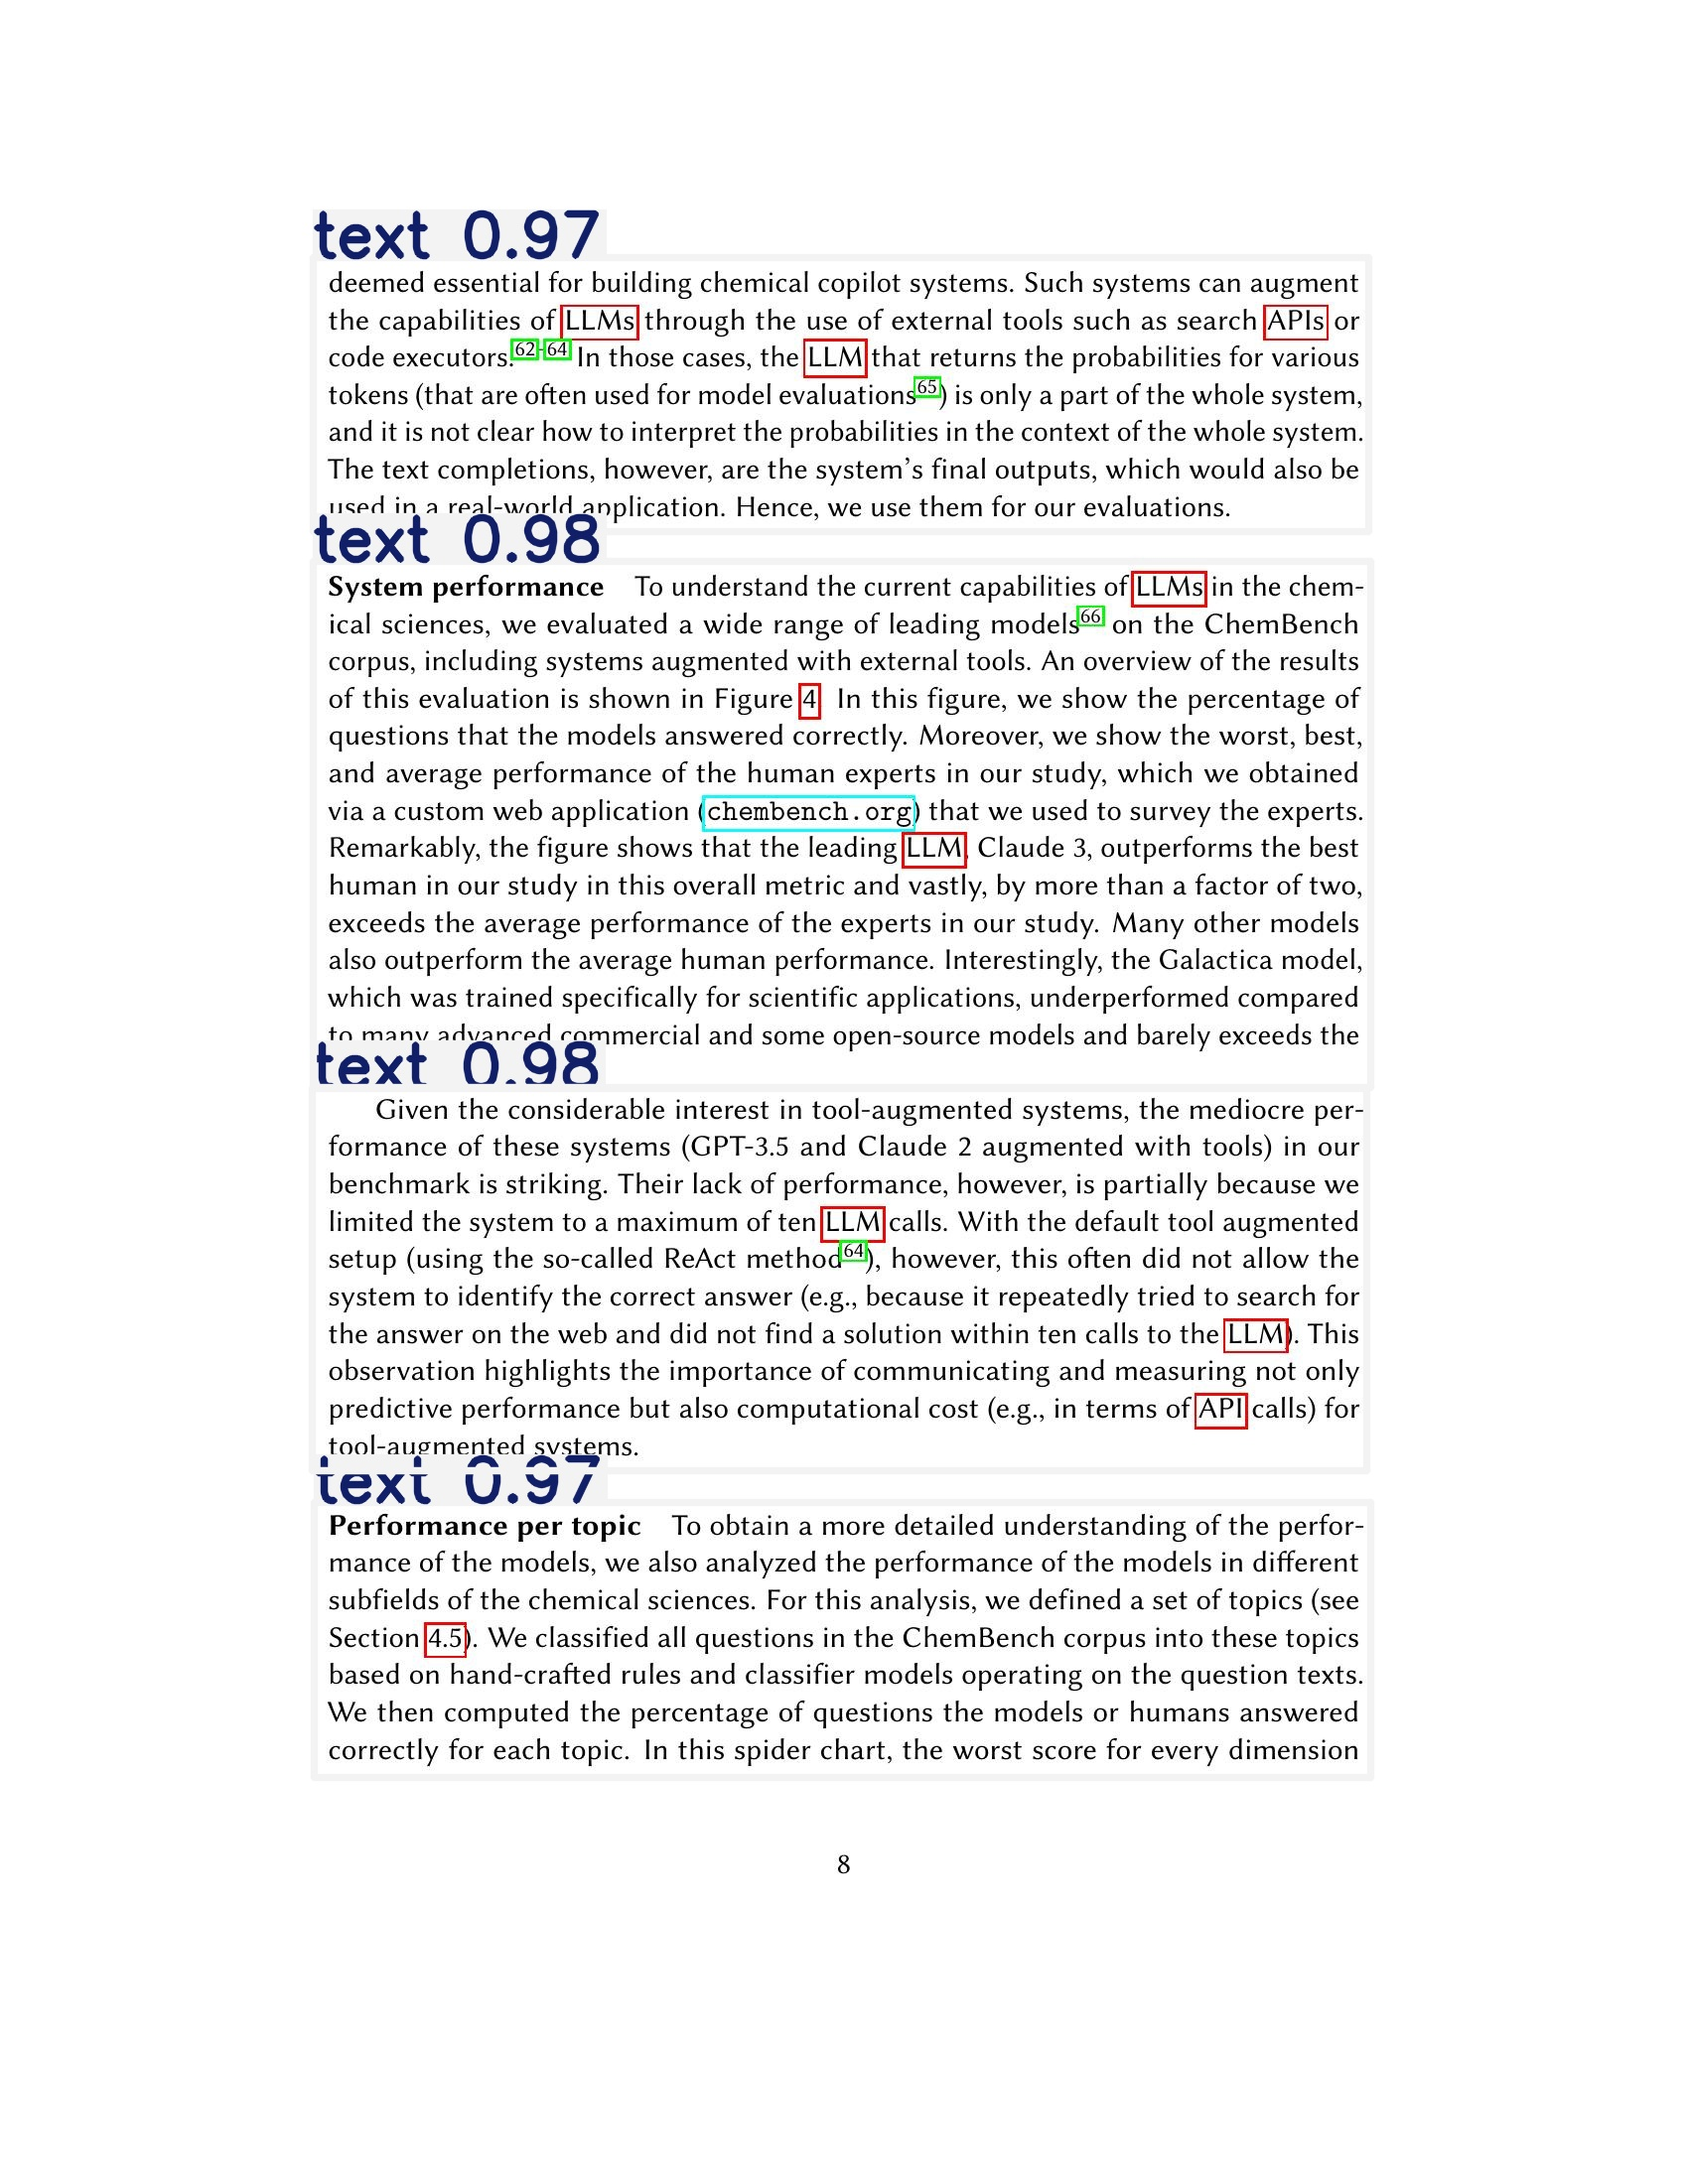

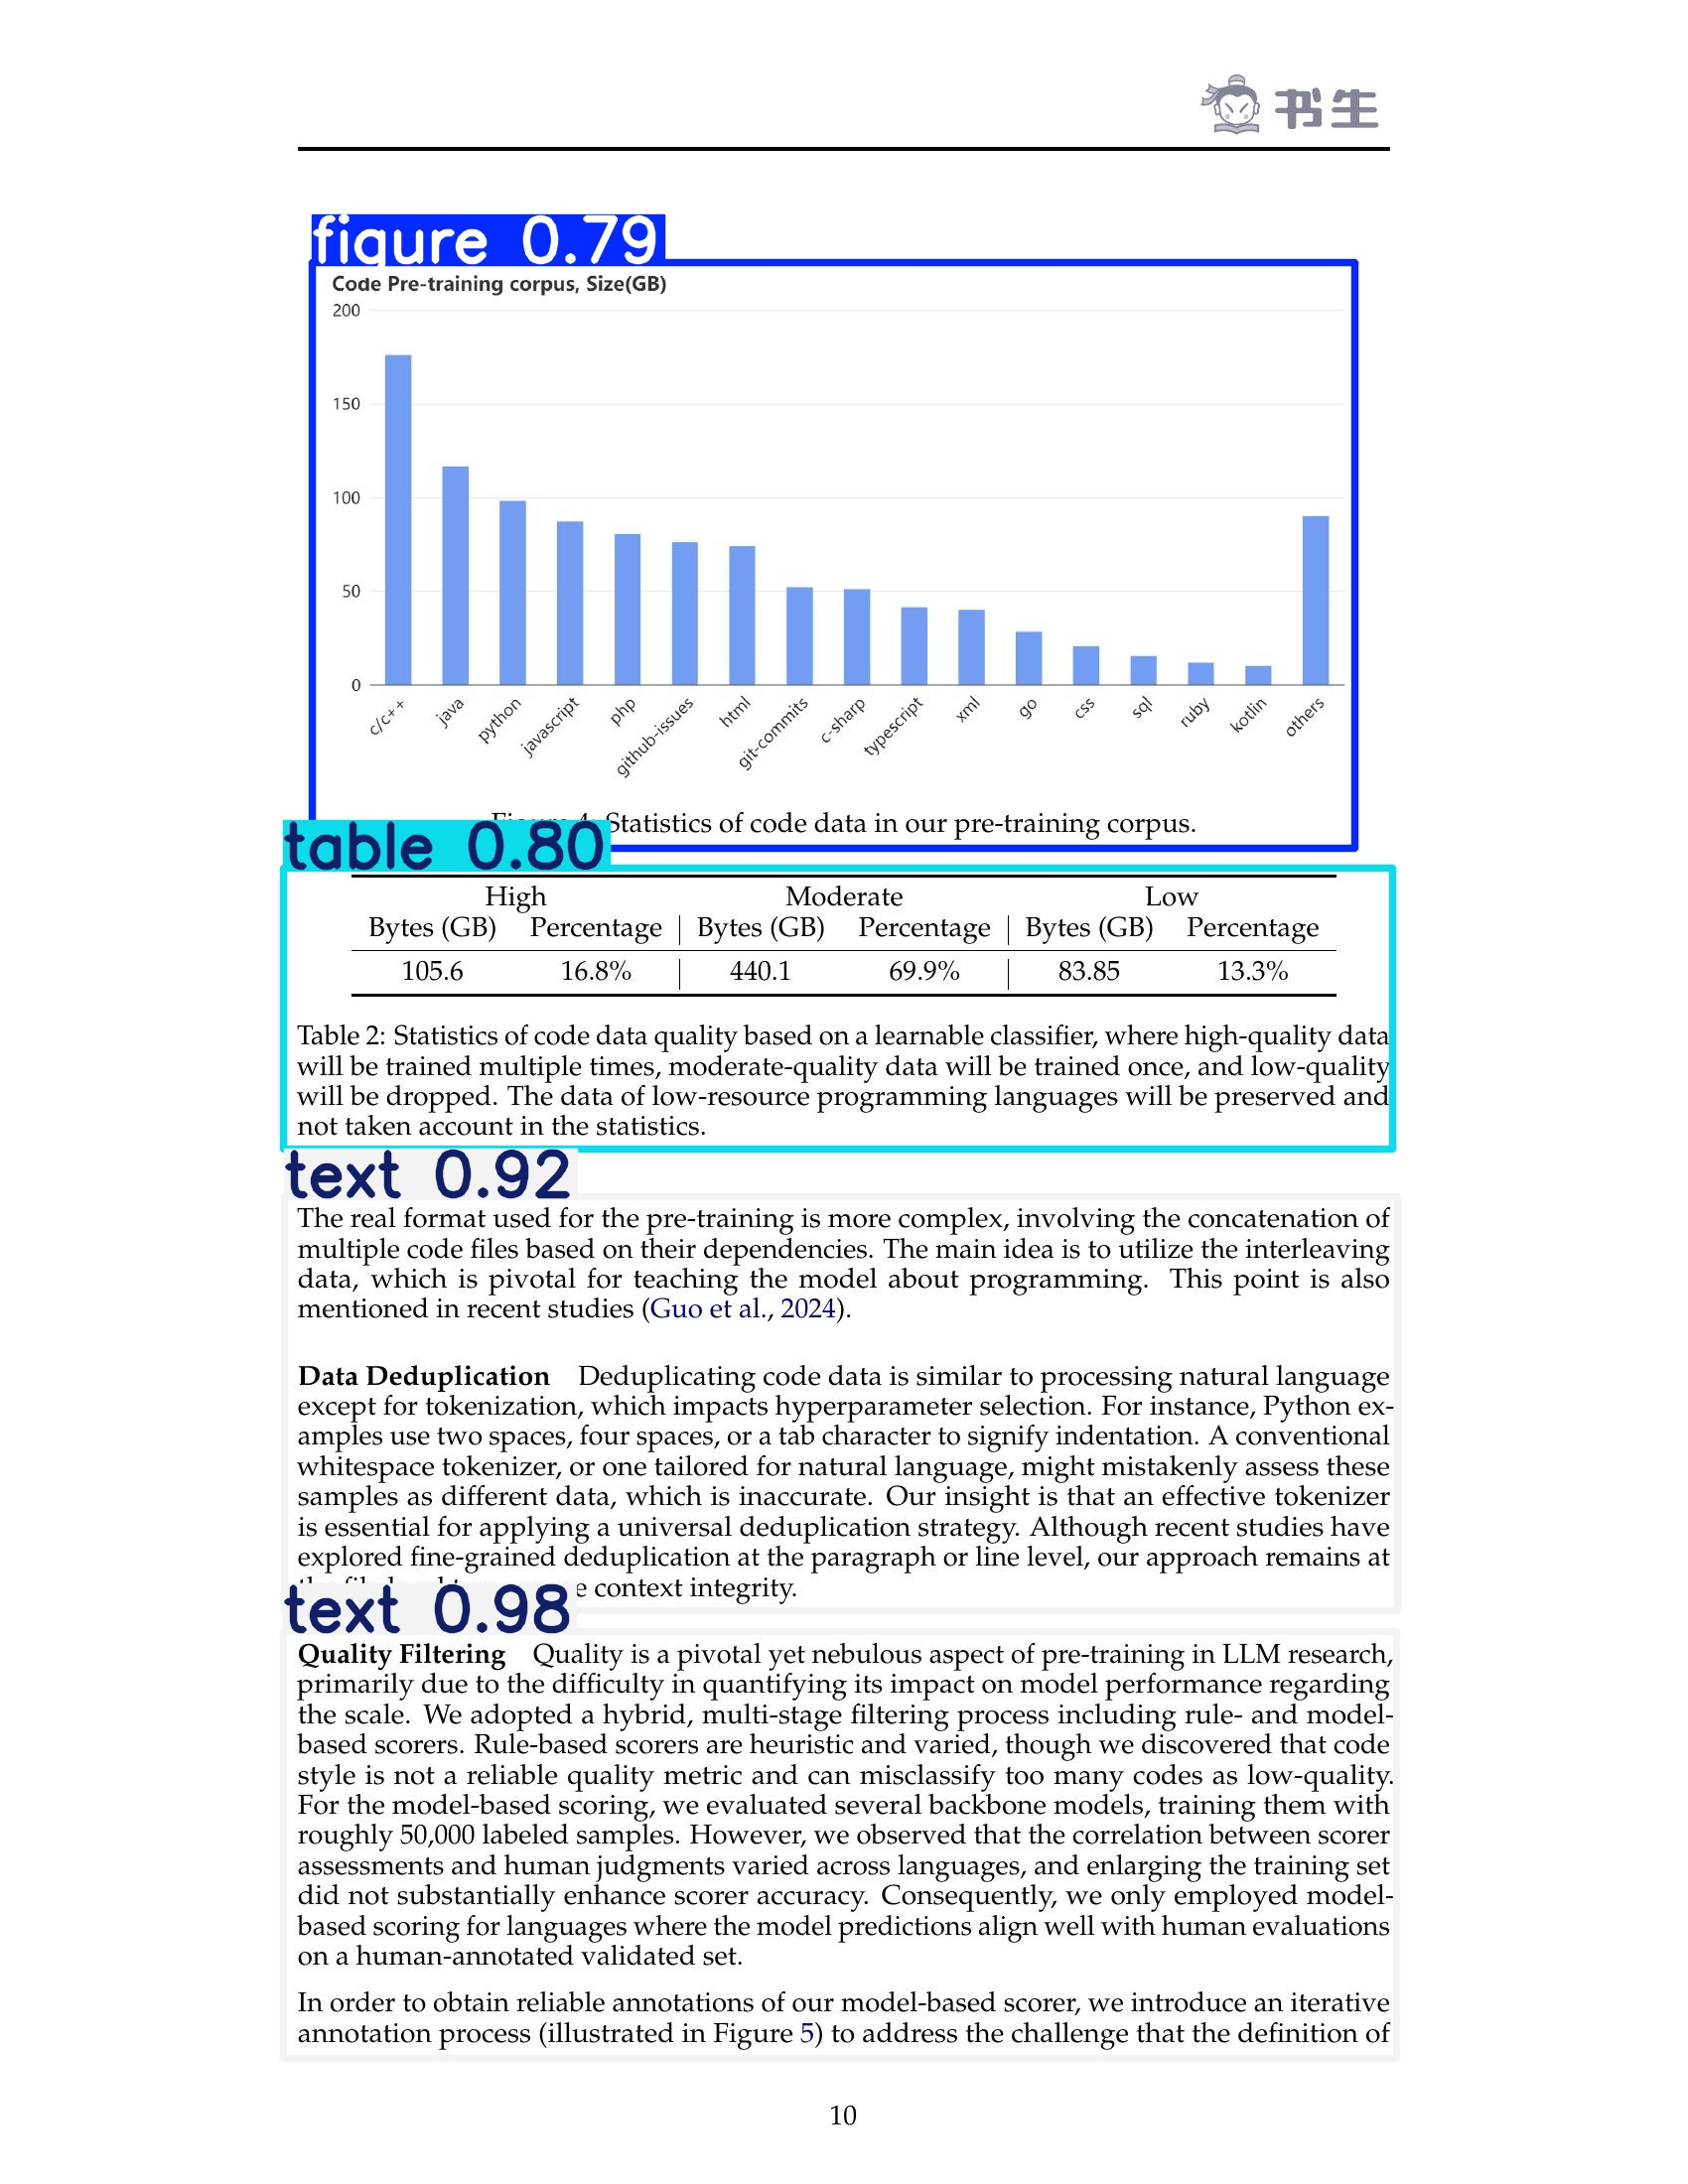

In [29]:
import glob
import os
from IPython.display import Image as IPyImage,display

latest_folder =max(glob.glob('/content/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
  display(IPyImage(filename=img,width=600))
  print("\n")


In [30]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [33]:
import os
import cv2
import numpy as np
import gradio as gr
from ultralytics import YOLO

model =YOLO('/content/runs/detect/train/weights/best.pt')

def detect_txt(image):
  """
  Detects text in the uploaded image using the yolov11 model and returns the proceed images
  """

  temp_image_path ="temp_input.jpg"
  image.save(temp_image_path)

  output_folder ="/content/runs/detect/predict"
  os.makedirs(output_folder,exist_ok=True)
  result.save(save_dir=output_folder)

  latest_folder = max(glob.glob(f'{output_folder}*/'), key=os.path.getmtime)
  output_image_path = glob.glob(f'{latest_folder}/*.jpg')[0]

  return output_image_path

# Define Gradio interface
interface = gr.Interface(
    fn=detect_txt,
    inputs=gr.Image(type="pil", label="Upload an Image"),
    outputs=gr.Image(type="filepath", label="Detected Objects"),
    title="Pdf-Text-Fifure-Detect",
    description="Upload an image to detect objects using your YOLO model. The output will display the image with bounding boxes."
)

interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://caa0078977f3ca4ded.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
